In [1]:
# general
import sys, os, path
import datetime

# nn related
import torch
import torch as th
import torch.nn as nn
import numpy as np
from numpy import linalg as la
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# postprocessing
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
import seaborn as sns

# own scrips
sys.path.insert(1, '/home/leonriccius/PycharmProjects/data_driven_rans')
from scripts import barymap as bm
# from barymap import BarMap
from scripts import TensorBasedNN
from scripts.TensorBasedNN import TBNN_generic
from scripts.utilities import mask_boundary_points

# standard datatype
dtype = torch.double

In [2]:
def time():
    return datetime.datetime.now().strftime("%y-%m-%d_%H-%M")

In [9]:
# set path to models and initialise arrays
model_path =  '../storage/models/kaandorp_data/ph_cdc/l2_regularization_1000ep_1000_bs' # 'trained_models'
model_names = os.listdir(model_path) # ['500epochs']
# model_names = [model_names[i] for i in [2, 0, 1]]
model_names = [model_names[5]]
print(model_names)
models = []
train_loss = []
val_loss = []

# loop over model names
for i, name in enumerate(model_names):
    print(os.sep.join([model_path, name, 'model.pt']))
    models.append(th.load(os.sep.join([model_path, name, 'model.pt'])))
    models[i].eval()  # mandatory, see torch.load doc
    train_loss.append(th.load(os.sep.join([model_path, name, 'loss_vector.th'])))
    val_loss.append(th.load(os.sep.join([model_path, name, 'val_loss_vector.th'])))

['1e+00']
../storage/models/kaandorp_data/ph_cdc/l2_regularization_1000ep_1000_bs/1e+00/model.pt


In [10]:
# # set path to models and initialise arrays
# model_path =  'trained_models'
# model_names = ['3cases_500_epochs_1e-5'] # os.listdir(model_path)
# print(model_names)
# models = []
# train_loss = []
# val_loss = []

# # loop over model names
# for i, name in enumerate(model_names):
#     print(os.sep.join([model_path, name, 'model.pt']))
#     models.append(th.load(os.sep.join([model_path, name, 'model.pt'])))
#     models[i].eval()  # mandatory, see torch.load doc
#     train_loss.append(th.load(os.sep.join([model_path, name, 'loss_vector.th'])))
#     val_loss.append(th.load(os.sep.join([model_path, name, 'val_loss_vector.th'])))

In [11]:
test = np.array([item for item in val_loss[i] for i in range(3)])

In [12]:
val_loss[0].shape

(1001,)

0.24854480246417077


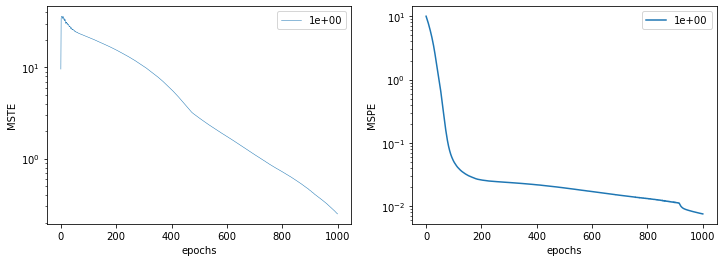

In [14]:
# plot training and validiation error of models
fig, ax = plt.subplots(1,2, figsize=(12,4))

for i,_ in enumerate(train_loss):
    ax[0].semilogy(np.arange(train_loss[i].shape[0]), train_loss[i], linewidth=0.5)
    ax[0].set_xlabel(r'epochs')
    ax[0].set_ylabel(r'MSTE')

    ax[1].semilogy(np.arange(val_loss[i].shape[0]), val_loss[i])
    ax[1].set_xlabel(r'epochs')
    ax[1].set_ylabel(r'MSPE')
    print(train_loss[i][-1])
    
ax[0].legend(model_names)
ax[1].legend(model_names)

In [15]:
# load in flowcase for testing
test_data_path =  '/home/leonriccius/Documents/Fluid_Data/test_data/periodic_hills/tensordata_normalized/'
# on workstation: /home/leon/Master_Thesis/Fluid_Data ...
cases = '2800'
curr_case = os.sep.join([test_data_path, cases])

# read in test case tensors
inv_test = th.load(os.sep.join([curr_case,'inv-torch.th']))
T_test = th.load(os.sep.join([curr_case,'T-torch.th'])).reshape(-1,10,9)
b_dns_test = th.load(os.sep.join([curr_case,'b_dns-torch.th']))
b_rans_test = th.load(os.sep.join([curr_case,'b_rans-torch.th']))
grid_test = th.load(os.sep.join([curr_case,'grid-torch.th']))

In [10]:
th.max(b_dns_test)
index = th.isnan(b_dns_test[:,0,0])
# print(b_dns_test[index])
b_dns_test_cut = b_dns_test[index==False]
grid_test_cut = grid_test[index==False]

### Barycentric Map

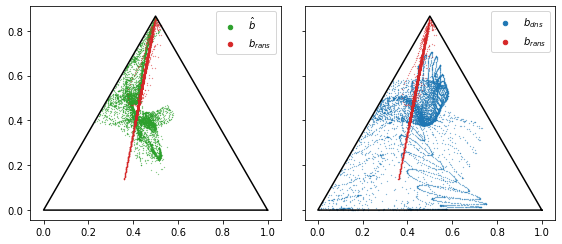

In [11]:
# get barycentric map for models
markersize = 0.05

# set path to save figures
# fig_path = '/home/leonriccius/Desktop'
fig_path = '/home/leonriccius/gkm/Masters_Thesis/Images/NN'

#loop over models
for i, model in enumerate(models):
    fig, ax = plt.subplots(1,2, figsize=(8,3.5), sharey=True)
    
    ax[0].axis('equal')
    ax[1].axis('equal')
    # get prediction and plot the datapoints
    b_pred, _ = model(inv_test, T_test)
    barm_pred = bm.BarMap()
    barm_pred.load_from_variable(b_pred.reshape(-1,3,3).detach().numpy(), grid_test)
    barm_pred.calculate_barycentric_coordinates()
    pred_data_points = barm_pred.plot_data_points(ax[0], color=sns.color_palette()[2], markersize=markersize)
    
    # plot the rans data points
    barm_rans = bm.BarMap()
    barm_rans.load_from_variable(b_rans_test.detach().numpy(), grid_test)
    barm_rans.calculate_barycentric_coordinates()
    rans_data_points = barm_rans.plot_data_points(ax[0], color=sns.color_palette()[3], markersize=markersize)
    ax[0].legend(['$\hat b$', '$b_{rans}$'],  markerscale=1./markersize)
    barm_pred.plot_triangle(ax[0])
    
    # plot the dns data points
    barm_dns = bm.BarMap()
    barm_dns.load_from_variable(b_dns_test.reshape(-1,3,3).detach().numpy(), grid_test_cut)
    barm_dns.calculate_barycentric_coordinates()
    barm_dns.plot_data_points(ax[1], color=sns.color_palette()[0], markersize=markersize)
    barm_rans.plot_data_points(ax[1], color=sns.color_palette()[3], markersize=markersize)
    ax[1].legend(['$b_{dns}$', '$b_{rans}$'],  markerscale=1./markersize)
    barm_dns.plot_triangle(ax[1])
    
    plt.tight_layout()
    
# save figure
fig_name = time() + '_phill_' + model_names[0] + '_barycentric_map.pdf'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='pdf')
# fig.suptitle(r'trained on ' + model_names[i], y=1.01, fontsize=14)

In [12]:
b_dns_test_unique = th.zeros(b_dns_test.shape[0],6)
b_dns_test_unique[:,0] = b_dns_test[:,0,0]
b_dns_test_unique[:,1] = b_dns_test[:,1,1]
b_dns_test_unique[:,2] = b_dns_test[:,2,2]
b_dns_test_unique[:,3] = b_dns_test[:,1,0]
b_dns_test_unique[:,4] = b_dns_test[:,1,2]
b_dns_test_unique[:,5] = b_dns_test[:,2,0]

b_rans_test_unique = th.zeros(b_dns_test.shape[0],6)
b_rans_test_unique[:,0] = b_rans_test[:,0,0]
b_rans_test_unique[:,1] = b_rans_test[:,1,1]
b_rans_test_unique[:,2] = b_rans_test[:,2,2]
b_rans_test_unique[:,3] = b_rans_test[:,1,0]
b_rans_test_unique[:,4] = b_rans_test[:,1,2]
b_rans_test_unique[:,5] = b_rans_test[:,2,0]


b_pred_test_unique = th.zeros(b_dns_test.shape[0],6)
b_pred_test_unique[:,0] = b_pred.reshape(-1,3,3)[:,0,0]
b_pred_test_unique[:,1] = b_pred.reshape(-1,3,3)[:,1,1]
b_pred_test_unique[:,2] = b_pred.reshape(-1,3,3)[:,2,2]
b_pred_test_unique[:,3] = b_pred.reshape(-1,3,3)[:,1,0]
b_pred_test_unique[:,4] = b_pred.reshape(-1,3,3)[:,1,2]
b_pred_test_unique[:,5] = b_pred.reshape(-1,3,3)[:,2,0]

In [13]:
loss_fn = torch.nn.MSELoss()
print('MSE from RANS: {:4f}'.format(th.nn.MSELoss()(b_dns_test, b_rans_test)))
print('MSE from RANS: {:4f}'.format(th.nn.MSELoss()(b_dns_test, b_pred.reshape(-1,3,3))))

MSE from RANS: 0.008916
MSE from RANS: 0.003543


In [14]:
rmse_rans = th.sqrt(th.nn.MSELoss()(b_dns_test_unique, b_rans_test_unique))
rmse_pred = th.sqrt(th.nn.MSELoss()(b_dns_test_unique, b_pred_test_unique))

print('RMSE from RANS: {:4f}'.format(rmse_rans))
print('RMSE from RANS: {:4f}'.format(rmse_pred))

RMSE from RANS: 0.111170
RMSE from RANS: 0.068067


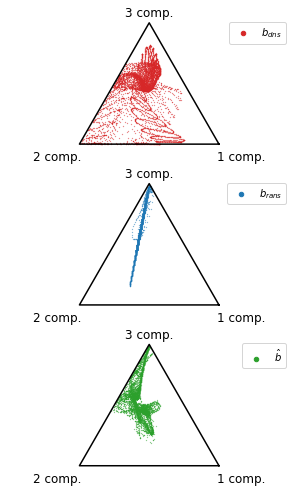

In [15]:
# get barycentric map for models
markersize = 0.05

# set path to save figures
# fig_path = '/home/leonriccius/Desktop'
fig_path = '/home/leonriccius/OneDrive/Dokumente/Uni/Masterthesis/midway_presentation'

#loop over models
for i, model in enumerate(models):
    fig, ax = plt.subplots(3,1, figsize=(4,6.7), sharey=True, constrained_layout=True)
    fig.set_constrained_layout_pads(w_pad=2/72, h_pad=2/72, hspace=0.0, wspace=0.0) #figsize=(3,6.7)
    
    ax[0].axis('equal')
    ax[0].axis('off')
    ax[1].axis('equal')
    ax[1].axis('off')
    ax[2].axis('equal')
    ax[2].axis('off')
    # get prediction and plot the datapoints
    b_pred, _ = model(inv_test, T_test)
    barm_pred = bm.BarMap()
    barm_pred.load_from_variable(b_pred.reshape(-1,3,3).detach().numpy(), grid_test)
    barm_pred.calculate_barycentric_coordinates()
    barm_pred.plot_data_points(ax[2], color=sns.color_palette()[2], markersize=markersize)
    ax[2].legend(['$\hat b$'],  markerscale=1./markersize)
    barm_pred.plot_triangle(ax[2])
    

    # plot the rans data points
    barm_rans = bm.BarMap()
    barm_rans.load_from_variable(b_rans_test.detach().numpy(), grid_test)
    barm_rans.calculate_barycentric_coordinates()
    barm_rans.plot_data_points(ax[1], color=sns.color_palette()[0], markersize=markersize)
    ax[1].legend(['$b_{rans}$'],  markerscale=1./markersize)
    barm_rans.plot_triangle(ax[1])
    
    # plot the dns data points
    barm_dns = bm.BarMap()
    barm_dns.load_from_variable(b_dns_test.reshape(-1,3,3).detach().numpy(), grid_test)
    barm_dns.calculate_barycentric_coordinates()
    barm_dns.plot_data_points(ax[0], color=sns.color_palette()[3], markersize=markersize)
    ax[0].legend(['$b_{dns}$'],  markerscale=1./markersize)
    barm_dns.plot_triangle(ax[0])
    
    for axs in ax.flat:
        axs.text(0.91, 0.00, '1 comp.', transform=axs.transAxes, fontsize=12,
            horizontalalignment='right', verticalalignment='top')
        axs.text(0.09, 0.00, '2 comp.', transform=axs.transAxes, fontsize=12,
            horizontalalignment='left', verticalalignment='top')
        axs.text(0.50, 0.98, '3 comp.', transform=axs.transAxes, fontsize=12,
            horizontalalignment='center', verticalalignment='bottom')


# save figure
fig_name = time() + '_phill_barycentric_map_pred.pdf'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='pdf')
# fig.suptitle(r'trained on ' + model_names[i], y=1.01, fontsize=14)

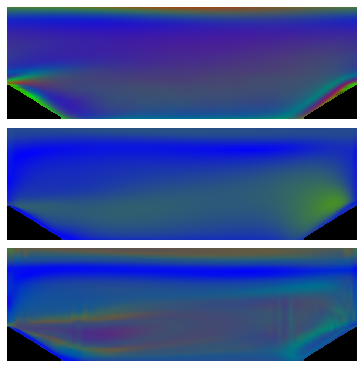

In [16]:
fig, ax = plt.subplots(3,1, figsize=(3*3.5,5), constrained_layout=True)

barm_rans.plot_on_geometry(ax[1], extent=[0.15,8.85,0.15,2.95], resolution=0.01)
barm_dns.plot_on_geometry(ax[0], extent=[0.15,8.85,0.15,2.95], resolution=0.01)
barm_pred.plot_on_geometry(ax[2], extent=[0.15,8.85,0.15,2.95], resolution=0.01)

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

# save figure
fig_name = time() + '_phill_barycentric_map_on_geom_with_pred.pdf'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='pdf')

### Comparison of $b$ for RANS, NN, and DNS

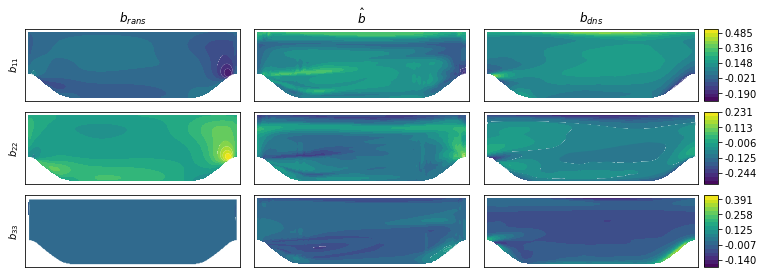

In [17]:
# predicts b for all models and plot the components
# grid for visualisation
grid_x, grid_y = np.mgrid[0.:9.:300j, 0.:3.035:100j]

# get mask for points selection
mask = mask_boundary_points(grid_x, grid_y)

# set path to save figures
fig_path = '/home/leonriccius/gkm/Masters_Thesis/Images/NN'
# fig_path = '/home/leonriccius/OneDrive/Dokumente/Uni/Masterthesis/midway_presentation'
# fig_path = '/home/leonriccius/Desktop'

# for i, model in enumerate(models):
model = models[0]

# get predicted b
b_pred, _ = model(inv_test, T_test)
b_pred = b_pred.reshape(-1,3,3)

# select components to plot
components = [[0,0], [1,1], [2,2]] # [[0,1], [1,2], [0,2]] # [[0,0], [1,1], [2,2]]

# set number of columns to plot
nrows = len(components)
ncols = 3

# create figure
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5*ncols, 1.25*nrows),
                        sharex=True, sharey=True, constrained_layout=True) # tight_layout=True)
# fig.subplots_adjust(right=0.8)

# loop over all 6 unique of b (symmetric), for pred of b, real b, and difference of these two
for i, idx in enumerate(components):
    # interpolate data on grid
    grid_b_rans = griddata(grid_test, b_rans_test.detach().numpy()[:,idx[0],idx[1]], (grid_x, grid_y), method='linear')
    grid_b_pred = griddata(grid_test, b_pred.detach().numpy()[:,idx[0],idx[1]], (grid_x, grid_y), method='linear')
    grid_b_test = griddata(grid_test, b_dns_test.detach().numpy()[:,idx[0],idx[1]], (grid_x, grid_y), method='linear')
    
    # set unwanted points to Nan
    grid_b_rans[~mask] = float('nan')
    grid_b_pred[~mask] = float('nan')
    grid_b_test[~mask] = float('nan')

    # get min an max of (b_pred, b_test) for colormap
    tmp = th.cat((b_rans_test[:,idx[0],idx[1]], b_pred[:,idx[0],idx[1]], b_dns_test[:,idx[0],idx[1]])).detach().numpy()
    b_min = np.min(tmp)
    b_max = np.max(tmp)
    levels = np.linspace(b_min, b_max, 20)

    # get the contour plots
    b_rans = axs.flat[3*i].contourf(grid_x, grid_y, grid_b_rans, levels=levels)
    axs.flat[3*i].set_xticks([])
    axs.flat[3*i].set_yticks([])
    b_nn = axs.flat[3*i+1].contourf(grid_x, grid_y, grid_b_pred, levels=levels)
    b_dns = axs.flat[3*i+2].contourf(grid_x, grid_y, grid_b_test, levels=levels)

    # remove contour lines
    for contour in [b_rans, b_nn, b_dns]:
        for c in contour.collections:
            c.set_edgecolor("face")
            c.set_linewidth(0.00000000000000001)
    
    # # get the colorbars (makes one colorbar per plot)
    # fig.colorbar(b_rans, ax=axs.flat[3*i], format='%.3f')
    # fig.colorbar(b_nn, ax=axs.flat[3*i+1], format='%.3f')
    # fig.colorbar(b_dns, ax=axs.flat[3*i+2], format='%.3f')
    
    # get colorbars (makes one colorbar per row)
    cbar = fig.colorbar(b_dns, ax=axs.flat[3*i:3*i+3], aspect=5*ncols*1, format='%.3f', pad=0.0)
    cbar.ax.locator_params(nbins=5)
    
    # set the component names
    axs[i,0].set_ylabel(r'$b_{'+str(idx[0]+1)+str(idx[1]+1)+'}$')

# set titles for columns
titles = [r'$b_{rans}$', r'$\hat b$', r'$b_{dns}$']
for i in range(3):
    axs[0,i].set_title(titles[i])

# save figure
fig_name = time() + '_phill_rans_nn_dns_common_colobar__off_diag.pdf'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='pdf')
# fig.suptitle(r'trained on ' + model_names[i], y=1.01, fontsize=14)

### Comparison of $\Delta b_{rans}$ and $\Delta \hat b$

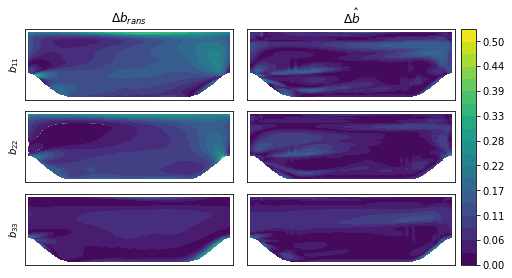

In [18]:
# predicts b for all models and plot the components
# grid for visualisation
grid_x, grid_y = np.mgrid[0.:9.:300j, 0.:3.035:100j]

# get mask for points selection
mask = mask_boundary_points(grid_x, grid_y)

# set path to save figures
# fig_path = '/home/leonriccius/Desktop'
# fig_path = '/home/leonriccius/gkm/Masters_Thesis/Images/NN'
fig_path = '/home/leonriccius/OneDrive/Dokumente/Uni/Masterthesis/midway_presentation'

# for i, model in enumerate(models):
# model = models[2]

# compute delta b
delta_b_rans = th.abs(b_rans_test - b_dns_test)
delta_b_nn = th.abs(b_pred - b_dns_test)

# get predicted b
b_pred, _ = model(inv_test, T_test)
b_pred = b_pred.reshape(-1,3,3)

# find min and max of the deltas for interval to be plotted
tmp = th.cat((delta_b_rans.flatten(), delta_b_nn.flatten())).detach().numpy()
b_min = np.min(tmp)
b_max = np.max(tmp)
levels_all = np.linspace(b_min, b_max, 20)

# select components to plot
components = [[0,0], [1,1], [2,2]] # [[0,1], [1,2], [0,2]]

# set number of columns to plot
ncols = 2
nrows = len(components)

# create figure
# fig, axs = plt.subplots(6,n_columns, figsize=(7*n_columns, 15), sharex=True, sharey=True, tight_layout=True)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5*ncols, 1.25*nrows),
                        sharex=True, sharey=True, constrained_layout=True)  # tight_layout=True)

# loop over all 6 unique of b (symmetric), for pred of b, real b, and difference of these two
for i, idx in enumerate(components):
    # interpolate data on grid
    grid_delta_b_rans = griddata(grid_test, delta_b_rans.detach().numpy()[:,idx[0],idx[1]], (grid_x, grid_y), method='linear')
    grid_delta_b_nn = griddata(grid_test, delta_b_nn.detach().numpy()[:,idx[0],idx[1]], (grid_x, grid_y), method='linear')
    
    # set unwanted points to Nan
    grid_delta_b_rans[~mask] = float('nan')
    grid_delta_b_nn[~mask] = float('nan')
    
    # get min an max of (b_diff_rans, b_diff_nn) for colormap
    tmp = th.cat((delta_b_rans[:,idx[0],idx[1]], delta_b_nn[:,idx[0],idx[1]])).detach().numpy()
    b_min = np.min(tmp)
    b_max = np.max(tmp)
    levels = np.linspace(b_min, b_max, 20)

    # get the contour plots
    plot_delta_b_rans = axs.flat[ncols*i].contourf(grid_x, grid_y, grid_delta_b_rans, levels=levels_all)
    axs.flat[ncols*i].set_xticks([])
    axs.flat[ncols*i].set_yticks([])
    plot_delta_b_nn = axs.flat[ncols*i+1].contourf(grid_x, grid_y, grid_delta_b_nn, levels=levels_all)

    # remove contour lines
    for contour in [plot_delta_b_rans, plot_delta_b_nn]:
        for c in contour.collections:
            c.set_edgecolor("face")
            c.set_linewidth(0.00000000000000001)
    
    # get the colorbars incase of one colobar per contourplot
    #fig.colorbar(plot_delta_b_rans, ax=axs.flat[n_columns*i], format='%.3f')
    #fig.colorbar(plot_delta_b_nn, ax=axs.flat[n_columns*i+1], format='%.3f')
    
    # set the component names
    axs[i,0].set_ylabel(r'$b_{'+str(idx[0]+1)+str(idx[1]+1)+'}$')

# set one colorbar for the whole figure
fig.colorbar(plot_delta_b_nn, ax=axs.flat, aspect=5*ncols*nrows, pad=0.0, format='%.2f')

# set titles
titles = [r'$\Delta b_{rans}$', r'$\Delta \hat b$']
for i in range(2):
    axs[0,i].set_title(titles[i])

# save figure
fig_name = time() + '_phill_delta_rans_nn_one_colobar_diagonal.pdf'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='pdf')
# fig.suptitle(r'trained on ' + model_names[i], y=1.01, fontsize=14)

### Variability of $b$ for differend $Re$

In [19]:
# load in all training cases
training_data_path = '/home/leonriccius/Documents/Fluid_Data/training_data/periodic_hills/tensordata'
cases = os.listdir(training_data_path)

# order list in ascending fashion
order  = [1,0,2,3]
cases = [cases[i] for i in order]
print(cases)

# initialize list for b_s
b_dns = []
for i, case in enumerate(cases):
    curr_path = os.sep.join([training_data_path, case, 'b_dns-torch.th'])
    b_dns.append(th.load(curr_path))
    
grid_dns = th.load(os.sep.join([training_data_path, cases[0], 'grid-torch.th']))

['700', '1400', '5600', '10595']


In [20]:
# grid for visualisation
grid_x, grid_y = np.mgrid[0.:9.:300j, 0.:3.035:100j]

# get mask for points selection
mask = mask_boundary_points(grid_x, grid_y)

# set path to save figures
# fig_path = '/home/leonriccius/Desktop'
fig_path = '/home/leonriccius/gkm/Masters_Thesis/Images/NN'

# find min and max of the deltas for interval to be plotted
tmp = th.cat((b_dns)).flatten().detach().numpy()
b_min = np.min(tmp)
b_max = np.max(tmp)
levels_all = np.linspace(b_min, b_max, 20)

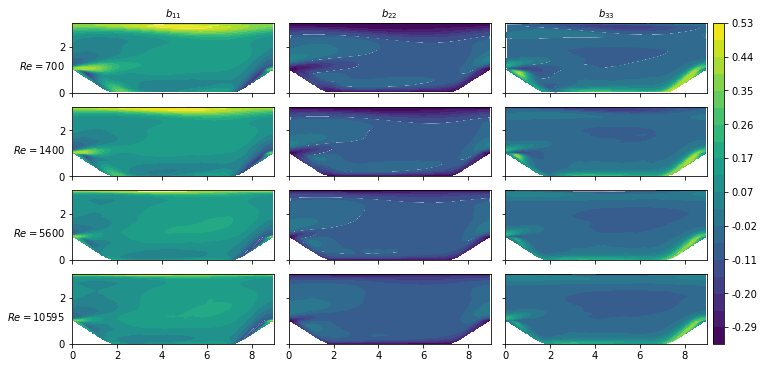

In [21]:
# select diagonal components to plot
components = [[0,0], [1,1], [2,2]]

# set number of columns to plot
ncols = len(components)
nrows = len(cases)

# create figure
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5*ncols, 1.25*nrows),
                        sharex=True, sharey=True, constrained_layout=True)

for i, idx in enumerate(components):
    for j, b0 in enumerate(b_dns):
        grid_b0 = griddata(grid_test, b0.detach().numpy()[:,idx[0],idx[1]],
                                     (grid_x, grid_y), method='linear')
        curr_plot = axs[j,i].contourf(grid_x, grid_y, grid_b0, levels_all)
        
        # remove contour lines
        for contour in [curr_plot]:
            for c in contour.collections:
                c.set_edgecolor("face")
                c.set_linewidth(0.00000000000000001)
    
    # set component description as title
    axs[0,i].set_title(r'$b_{'+str(idx[0]+1)+str(idx[1]+1)+'}$', fontsize='medium')

# set row description as text field
for i, case in enumerate(cases):
    axs[i,0].text(0, 1, '$Re='+case+'$   ', fontsize='medium', ha='right')

# set one colorbar for the whole figure
fig.colorbar(curr_plot, ax=axs.flat, aspect=5*ncols*nrows, pad=0.0, format='%.2f')

# save figure
fig_name = time() + '_phill_variation_of_b_diagonal.pdf'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='pdf')

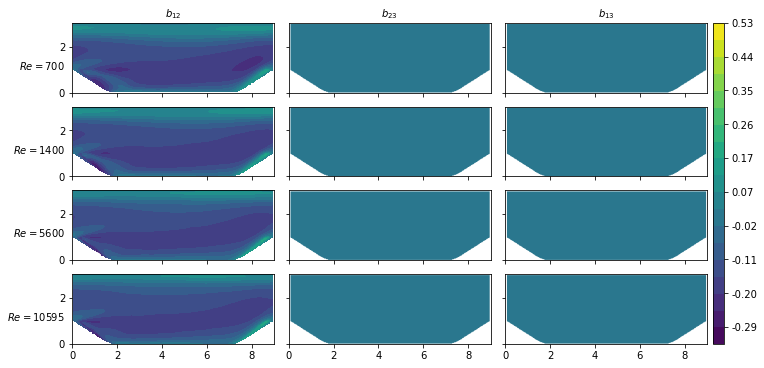

In [22]:
# select shear components to plot
components = [[0,1], [1,2], [0,2]]

# set number of columns to plot
ncols = len(components)
nrows = len(cases)

# create figure
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5*ncols, 1.25*nrows),
                        sharex=True, sharey=True, constrained_layout=True)

for i, idx in enumerate(components):
    for j, b0 in enumerate(b_dns):
        grid_b0 = griddata(grid_test, b0.detach().numpy()[:,idx[0],idx[1]],
                                     (grid_x, grid_y), method='linear')
        curr_plot = axs[j,i].contourf(grid_x, grid_y, grid_b0, levels_all)
        # remove contour lines
        for contour in [curr_plot]:
            for c in contour.collections:
                c.set_edgecolor("face")
                c.set_linewidth(0.00000000000000001)
        
        # set component description as title
        axs[0,i].set_title(r'$b_{'+str(idx[0]+1)+str(idx[1]+1)+'}$', fontsize='medium')

# set row description as text field
for i, case in enumerate(cases):
    axs[i,0].text(0, 1, '$Re='+case+'$   ', fontsize='medium', ha='right')
# set one colorbar for the whole figure
fig.colorbar(curr_plot, ax=axs.flat, aspect=5*ncols*nrows, pad=0.0, format='%.2f')

# save figure
fig_name = time() + '_phill_variation_of_b_off_diagonal.pdf'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='pdf')

### Results in slices

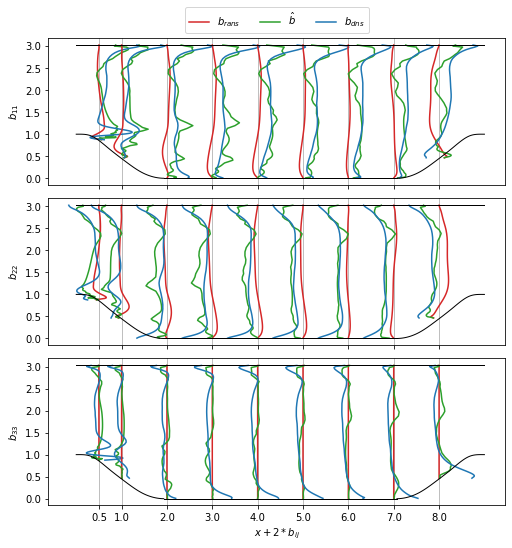

In [23]:
# set path to save figures
# fig_path = '/home/leonriccius/Desktop'
fig_path = '/home/leonriccius/gkm/Masters_Thesis/Images/NN'

# select x locations to plot
x_data = [0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
tol = 4e-2

# select components
components = [[0,0], [1,1], [2,2]]

# set number of columns to plot
ncols = 1
nrows = len(components)

# create figure
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7*ncols, 2.5*nrows),
                        sharex=True, sharey=True, constrained_layout=True)
plt.xticks(x_data)

for i, cmp in enumerate(components):
    for j, val in enumerate(x_data):
        # find x location in grid
        x_loc = np.argmin(np.absolute(grid_test[:,0].detach().numpy() - val))
        x_val = grid_test[x_loc, 0].detach().numpy()

        # create mask and select points in the slice
        mask = np.where(np.absolute(grid_test[:,0] - x_val) < tol)
        grid_slice = grid_test[mask].detach().numpy()
        b_dns_slice = b_dns_test[mask].detach().numpy()
        b_rans_slice = b_rans_test[mask].detach().numpy()
        b_nn_slice = b_pred[mask].detach().numpy()

        # plot all bs for current slice
        axs[i].plot(2*b_rans_slice[:,cmp[0],cmp[1]] + val, grid_slice[:,1],
                   color=sns.color_palette()[3]) #, label = r'$b_{rans}')
        axs[i].plot(2*b_nn_slice[:,cmp[0],cmp[1]] + val, grid_slice[:,1],
                   color=sns.color_palette()[2]) #, label = r'$\hat b$')
        axs[i].plot(2*b_dns_slice[:,cmp[0],cmp[1]] + val, grid_slice[:,1],
                   color=sns.color_palette()[0]) #, label = r'$b_{dns}$')
        axs[i].set_ylabel(r'$b_{'+str(cmp[0]+1)+str(cmp[1]+1)+'}$')
    
    # plot lower and upper wall of hill and grid
    bm.plot_periodic_hills_boundaries(axs[i])
    axs[i].grid(axis='x')

# plot legend    
axs[0].legend([r'$b_{rans}$', r'$\hat b$', r'$b_{dns}$'], bbox_to_anchor=(0.5, 1.00), loc='lower center', ncol=3)

# plot xlabel
axs[-1].set_xlabel(r'$x + 2*b_{ij}$')

# save figure
fig_name = time() + '_phill_b_on_slices.pdf'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='pdf')

### Barycentric map four some slices

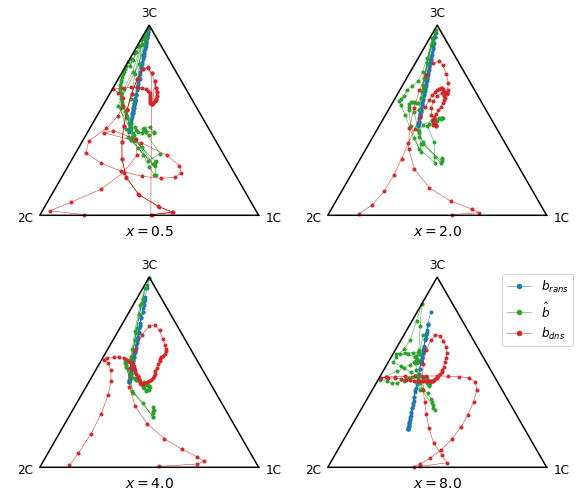

In [24]:
# set path to save figures
# fig_path = '/home/leonriccius/Desktop'
# fig_path = '/home/leonriccius/gkm/Masters_Thesis/Images/NN'
fig_path = '/home/leonriccius/OneDrive/Dokumente/Uni/Masterthesis/midway_presentation/'

# select x locations to plot
x_data = [0.5, 2.0, 4.0, 8.0] # , 4.0, 5.0, 6.0, 7.0, 8.0]
tol = 5e-2

nrows = 2
ncols = int(len(x_data)/nrows)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3.5*nrows), sharey=True, constrained_layout=True)
# ax[1].axis('equal')
fig.set_constrained_layout_pads(w_pad=2/72, h_pad=10/72, hspace=0.0, wspace=0.0)

markersize=3

for i, val in enumerate(x_data):
    # find x location in grid
    x_loc = np.argmin(np.absolute(grid_test[:,0].detach().numpy() - val))
    x_val = grid_test[x_loc, 0].detach().numpy()
    
    # create mask and select points in the slice
    mask = np.where(np.absolute(grid_test[:,0] - x_val) < tol)
    grid_slice = grid_test[mask].detach().numpy()
    b_dns_slice = b_dns_test[mask].detach().numpy()
    b_rans_slice = b_rans_test[mask].detach().numpy()
    b_nn_slice = b_pred[mask].detach().numpy()

    # plot the rans data points
    barm_rans = bm.BarMap()
    barm_rans.load_from_variable(b_rans_slice, grid_slice)
    barm_rans.calculate_barycentric_coordinates()
    rans_data_points = barm_rans.plot_data_line(axs.flat[i], color=sns.color_palette()[0], markersize=markersize, linewidth=0.5)
    
    # get prediction and plot the datapoints
    barm_pred = bm.BarMap()
    barm_pred.load_from_variable(b_nn_slice, grid_slice)
    barm_pred.calculate_barycentric_coordinates()
    axs.flat[i].axis('equal')
    pred_data_points = barm_pred.plot_data_line(axs.flat[i], color=sns.color_palette()[2], markersize=markersize, linewidth=0.5)
    
    # plot the dns data points
    barm_dns = bm.BarMap()
    barm_dns.load_from_variable(b_dns_slice, grid_slice)
    barm_dns.calculate_barycentric_coordinates()
    barm_dns.plot_data_line(axs.flat[i], color=sns.color_palette()[3], markersize=markersize, linewidth=0.5)
    barm_dns.plot_triangle(axs.flat[i])
    
    # set titles
    # axs.flat[i].set_title(r'$x = $' + str(val))
    axs.flat[i].text(0.5, 0.00, r'$x = $' + str(val), transform=axs.flat[i].transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='center')
    
    # remove axis
    axs.flat[i].axis('off')
    
    # description of limiting states
    axs.flat[i].text(0.91, 0.00, '1C', transform=axs.flat[i].transAxes, fontsize=12,
        horizontalalignment='left', verticalalignment='bottom')
    axs.flat[i].text(0.09, 0.00, '2C', transform=axs.flat[i].transAxes, fontsize=12,
        horizontalalignment='right', verticalalignment='bottom')
    axs.flat[i].text(0.50, 0.98, '3C', transform=axs.flat[i].transAxes, fontsize=12,
        horizontalalignment='center', verticalalignment='bottom')

axs.flat[nrows*ncols-1].legend([r'$b_{rans}$', r'$\hat b$', r'$b_{dns}$'], fontsize=12, markerscale=1.5)

# save figure
fig_name = time() + '_phill_barmap_05-2-4-8.pdf'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='pdf')

In [24]:
# for bold italic in math context
# plt.rcParams['mathtext.fontset'] = 'custom'
# plt.rcParams['mathtext.it'] = 'STIXGeneral:italic'
# plt.rcParams['mathtext.bf'] = 'STIXGeneral:italic:bold'